In [79]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import pandas as pd
import numpy as np
from collections import defaultdict
import os
import gc

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

from sklearn.model_selection import train_test_split


from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import f1_score

from tqdm import tqdm
import joblib


# model
import lightgbm as lgb

SEED=42
LABEL=None

In [0]:
path = '/content/drive/My Drive/bigcontest2019/'
os.chdir(path)

In [0]:
train_activity = pd.read_csv('data/train/train_activity.csv').drop(columns='fishing')
train_combat = pd.read_csv('data/train/train_combat.csv')
train_payment = pd.read_csv('data/train/train_payment.csv')
train_pledge = pd.read_csv('data/train/train_pledge.csv').drop(columns=['combat_play_time', 'non_combat_play_time'])
train_trade = pd.read_csv('data/train/train_trade.csv')

test1_activity = pd.read_csv('data/test/test1_activity.csv').drop(columns='fishing')
test1_combat = pd.read_csv('data/test/test1_combat.csv')
test1_payment = pd.read_csv('data/test/test1_payment.csv')
test1_pledge = pd.read_csv('data/test/test1_pledge.csv').drop(columns=['combat_play_time', 'non_combat_play_time'])
test1_trade = pd.read_csv('data/test/test1_trade.csv')

test2_activity = pd.read_csv(path + 'data/test/test2_activity.csv').drop(columns='fishing')
test2_combat = pd.read_csv(path + 'data/test/test2_combat.csv')
test2_payment = pd.read_csv(path + 'data/test/test2_payment.csv')
test2_pledge = pd.read_csv(path + 'data/test/test2_pledge.csv').drop(columns=['combat_play_time', 'non_combat_play_time'])
test2_trade = pd.read_csv(path + 'data/test/test2_trade.csv')

train_label = pd.read_csv('data/train/train_label.csv')
true_train_label = train_label.copy()

In [0]:
class data_transform(object):
    def __init__(self, data):
        self.data = data
        
    def create_week(self):
        self.data['week'] = (self.data['day']-1)//7 + 1
        return self.data
    
    def activity_transform(self):
        temp_df = self.data
        groupby_dict = defaultdict()
        
        temp_df = pd.get_dummies(temp_df)
        
        for feature in temp_df.columns:
            if feature == 'acc_id' or feature == 'week':
                pass
            elif feature == 'day' or feature == 'char_id':
                groupby_dict[feature] = 'nunique'
            else:
                groupby_dict[feature] = ['sum', 'mean', 'min', 'max']
        else:        
            temp_df = temp_df.groupby(['acc_id', 'week']).agg(groupby_dict).reset_index()
            temp_df.columns = [i+j for i,j in temp_df.columns.ravel()]
        return temp_df
    
    def payment_transform(self):
        output_df = self.data
        groupby_dict = defaultdict()
        
        for feature in output_df.columns:
            if feature == 'acc_id' or feature == 'week':
                pass
            elif feature == 'day':
                groupby_dict[feature] = 'nunique'
            else:
                groupby_dict[feature] = ['sum', 'mean', 'min', 'max']
        else:
            output_df = output_df.groupby(['acc_id', 'week']).agg(groupby_dict).reset_index()
            output_df.columns = [i+j for i,j in output_df.columns.ravel()]
        
        return output_df
    
    def trade_transform(self):
        output_df = self.data
        groupby_dict = defaultdict()
        groupby_dict2 = defaultdict()
        
        output_df['time'] = output_df['time'].apply(lambda x: str(x)[:2])
        output_df[['time', 'type', 'server']] = output_df[['time', 'type', 'server']].astype(object)
        output_df = pd.get_dummies(output_df)
        output_df2 = output_df.copy()
        
        output_df = output_df.rename(columns={'source_acc_id':'acc_id'})
        output_df2 = output_df2.rename(columns={'target_acc_id':'acc_id'})
        
        for feature in output_df.columns:
            if feature == 'acc_id' or feature == 'week':
                pass
            elif feature in ['day', 'item_type', 'source_char_id', 'target_char_id', 'target_acc_id']:
                groupby_dict[feature] = 'nunique'
            else:
                groupby_dict[feature] = ['sum', 'mean', 'min', 'max']
        else:
            output_df = output_df.groupby(['acc_id', 'week']).agg(groupby_dict).reset_index()
            output_df.columns = [i+j for i,j in output_df.columns.ravel()]
        
        for feature in output_df2.columns:
            if feature == 'acc_id' or feature == 'week':
                pass
            elif feature in ['day', 'item_type', 'source_char_id', 'target_char_id', 'source_acc_id']:
                groupby_dict2[feature] = 'nunique'
            else:
                groupby_dict2[feature] = ['sum', 'mean', 'min', 'max']
        else:
            output_df2 = output_df2.groupby(['acc_id', 'week']).agg(groupby_dict2).reset_index()
            output_df2.columns = [i+j for i,j in output_df2.columns.ravel()]
        
        output_df = pd.merge(output_df, output_df2, how='outer', on=['acc_id', 'week'])
        
        return output_df
    
    def combat_transform(self):
        output_df = self.data
        groupby_dict = defaultdict()
        
        output_df[['server', 'class', 'level']] = output_df[['server', 'class', 'level']].astype(str)
        output_df = pd.get_dummies(output_df)
        
        for feature in output_df.columns:
            if feature == 'acc_id' or feature == 'week':
                pass
            elif feature == 'day':
                groupby_dict[feature] = 'nunique'
            elif feature == 'char_id':
                groupby_dict[feature] = ['nunique', 'size']
            else:
                groupby_dict[feature] = ['sum', 'mean', 'min', 'max']
        else:
            output_df = output_df.groupby(['acc_id', 'week']).agg(groupby_dict).reset_index()
            output_df.columns = [i+j for i,j in output_df.columns.ravel()]
        
        return output_df
    
    def pledge_transform(self):
        output_df = self.data
        groupby_dict = defaultdict()
        
        output_df[['server']] = output_df[['server']].astype(str)
        output_df = pd.get_dummies(output_df)
        
        for feature in output_df.columns:
            if feature == 'acc_id' or feature == 'week':
                pass
            elif feature in ['day', 'pledge_id']:
                groupby_dict[feature] = 'nunique'
            elif feature == 'char_id':
                groupby_dict[feature] = ['nunique', 'size']
            else:
                groupby_dict[feature] = ['sum', 'mean', 'min', 'max']
        else:
            output_df = output_df.groupby(['acc_id', 'week']).agg(groupby_dict).reset_index()
            output_df.columns = [i+j for i,j in output_df.columns.ravel()]
        return output_df

## train

In [0]:
train_activity['game_money_change_abs'] = np.abs(train_activity['game_money_change'])
transform = data_transform(train_activity)
transform.create_week()
act_train = transform.activity_transform()
################################################################################################
transform = data_transform(train_payment)
transform.create_week()
pay_train = transform.payment_transform()
################################################################################################
trandform = data_transform(train_trade)
trandform.create_week()
tra_train = trandform.trade_transform()
################################################################################################
trandform = data_transform(train_combat)
trandform.create_week()
com_train = trandform.combat_transform()
################################################################################################
trandform = data_transform(train_pledge)
trandform.create_week()
ple_train = trandform.pledge_transform()

## test

In [0]:
test1_activity['game_money_change_abs'] = np.abs(test1_activity['game_money_change'])
transform = data_transform(test1_activity)
transform.create_week()
act_test1 = transform.activity_transform()

test2_activity['game_money_change_abs'] = np.abs(test2_activity['game_money_change'])
transform = data_transform(test2_activity)
transform.create_week()
act_test2 = transform.activity_transform()
################################################################################################
transform = data_transform(test1_payment)
transform.create_week()
pay_test1 = transform.payment_transform()

transform = data_transform(test2_payment)
transform.create_week()
pay_test2 = transform.payment_transform()
################################################################################################
trandform = data_transform(test1_trade)
trandform.create_week()
tra_test1 = trandform.trade_transform()

trandform = data_transform(test2_trade)
trandform.create_week()
tra_test2 = trandform.trade_transform()
################################################################################################
trandform = data_transform(test1_combat)
trandform.create_week()
com_test1 = trandform.combat_transform()

trandform = data_transform(test2_combat)
trandform.create_week()
com_test2 = trandform.combat_transform()
################################################################################################
trandform = data_transform(test1_pledge)
trandform.create_week()
ple_test1 = trandform.pledge_transform()

trandform = data_transform(test2_pledge)
trandform.create_week()
ple_test2 = trandform.pledge_transform()

## model

In [0]:
train = pd.merge(pd.merge(pd.merge(pd.merge(act_train, pay_train, how='left', on=['acc_id', 'week']), tra_train, how='left', on=['acc_id', 'week']), com_train, how='left', on=['acc_id', 'week']), ple_train, how='left', on=['acc_id', 'week']).fillna(0)
test1 = pd.merge(pd.merge(pd.merge(pd.merge(act_test1, pay_test1, how='left', on=['acc_id', 'week']), tra_test1, how='left', on=['acc_id', 'week']), com_test1, how='left', on=['acc_id', 'week']), ple_test1, how='left', on=['acc_id', 'week']).fillna(0)
test2 = pd.merge(pd.merge(pd.merge(pd.merge(act_test2, pay_test2, how='left', on=['acc_id', 'week']), tra_test2, how='left', on=['acc_id', 'week']), com_test2, how='left', on=['acc_id', 'week']), ple_test2, how='left', on=['acc_id', 'week']).fillna(0)

In [0]:
train['total']

In [0]:
train_c = pd.merge(train, train_label[['acc_id', 'survival_time','amount_spent']], how='left', on='acc_id').dropna().reset_index(drop=True)

In [0]:
for week in range(1, 5):
    train_c.loc[train_c['week']==week, 'adjust_survival_time'] = np.minimum(64, train_c.loc[train['week']==week, 'survival_time'] + 7*(4-week))
train_c['adjust_survival_time'] += train_c['week']*7

In [74]:
train_c['adjust_survival_time'].unique()

array([71., 78., 85., 92., 88., 73., 31., 41., 50., 70., 43., 42., 57.,
       65., 30., 74., 36., 55., 49., 29., 64., 33., 47., 81., 48., 35.,
       32., 53., 56., 38., 89., 80., 34., 44., 66., 79., 83., 39., 40.,
       62., 86., 68., 45., 60., 90., 67., 91., 76., 82., 54., 69., 61.,
       87., 75., 59., 63., 37., 51., 46., 52., 72., 58., 77., 84.])

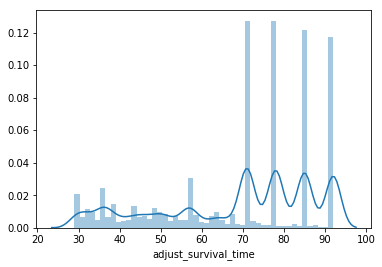

In [44]:
sns.distplot(train_c['adjust_survival_time'])

In [50]:
train_c['adjust_survival_time'].apply(lambda x: x if x==1 or x==64 else x//7*7).apply(lambda x: 1 if x==0 else x)

0         56.0
1         49.0
2         42.0
3         35.0
4         42.0
5         35.0
6         35.0
7         56.0
8         49.0
9         42.0
10        35.0
11        56.0
12        49.0
13        42.0
14        35.0
15        56.0
16        49.0
17        42.0
18        35.0
19        56.0
20        49.0
21        42.0
22        35.0
23        35.0
24        35.0
25        35.0
26        35.0
27        56.0
28        49.0
29        42.0
          ... 
149196    56.0
149197    49.0
149198    42.0
149199    35.0
149200    56.0
149201    49.0
149202    42.0
149203    35.0
149204     7.0
149205    56.0
149206    49.0
149207    42.0
149208    35.0
149209    56.0
149210    49.0
149211    42.0
149212    35.0
149213     1.0
149214    56.0
149215    49.0
149216    42.0
149217    35.0
149218    56.0
149219    49.0
149220    42.0
149221    35.0
149222    56.0
149223    49.0
149224    42.0
149225    35.0
Name: adjust_survival_time, Length: 149226, dtype: float64

In [60]:
(train_c['survival_time'].apply(lambda x: x if x==1 or x==64 else x//7*7).apply(lambda x: 1 if x==0 else x)).value_counts()

64    85874
7     11129
28     9920
1      9254
14     8190
21     7687
35     5833
56     4046
42     3482
49     3460
63      351
Name: survival_time, dtype: int64

In [0]:
 train_s = pd.read_csv('/content/train.csv')

In [111]:
train.shape

(149226, 1224)

In [112]:
train_s.columns

Index(['acc_id', 'week', 'daynunique_x_x', 'char_idnunique_x', 'playtimesum',
       'playtimemean', 'playtimemin', 'playtimemax', 'npc_killsum',
       'npc_killmean',
       ...
       'server_bomin', 'server_bomax', 'server_bpsum', 'server_bpmean',
       'server_bpmin', 'server_bpmax', 'server_brsum', 'server_brmean',
       'server_brmin', 'server_brmax'],
      dtype='object', length=1224)

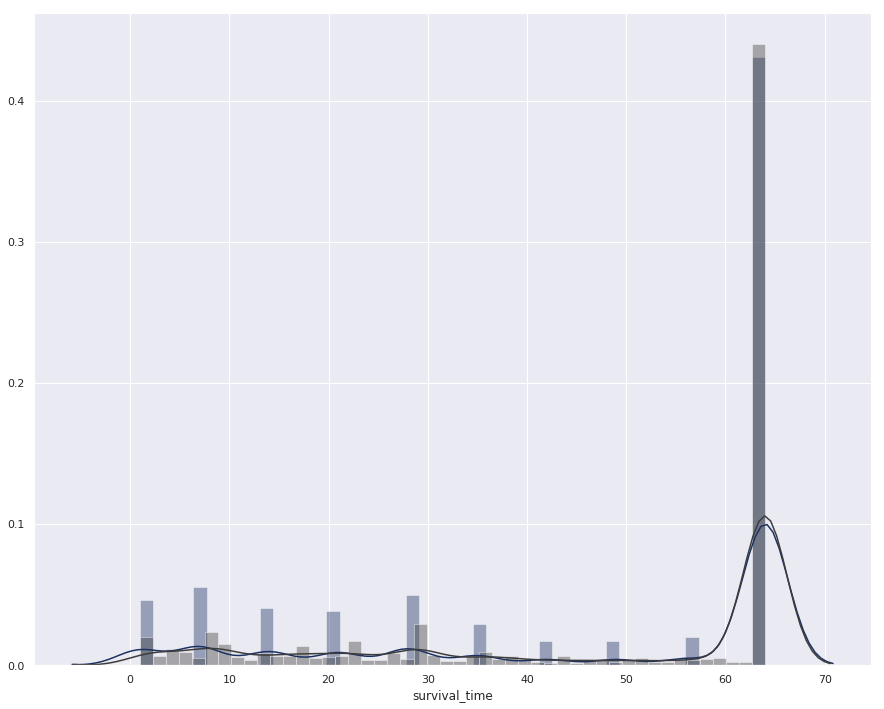

In [61]:
sns.set(rc={'figure.figsize':(15,12)})
sns.distplot(train_c['survival_time'].apply(lambda x: x if x==1 or x==64 else x//7*7).apply(lambda x: 1 if x==0 else x),color='#1C3061')
sns.distplot(train_c['survival_time'],color='#3C3C3C')

# sns.distplot(train['survival_time'])

In [0]:
def temp_func(data):
    if data['adjust_survival_time']>64:
        over_value = data['adjust_survival_time'] - 64
        data['adjust_survival_time'] = data['survival_time'] - over_value
    else:
        data['adjust_survival_time'] = data['survival_time']
    return data['adjust_survival_time']

train_c['adjust_survival_time'] = train_c[['survival_time', 'adjust_survival_time']].apply(temp_func, axis=1)


In [0]:
for idx, true in enumerate(np.unique(train_c['survival_time'].apply(lambda x: x if x==1 or x==64 else x//7*7).apply(lambda x: 1 if x==0 else x))):
            self.true_index[true] = idx
        else:
            self.train_data[LABEL] = self.train_data[LABEL].apply(lambda x: x if x==1 or x==64 else x//7*7).apply(lambda x: 1 if x==0 else x).apply(lambda x: self.true_index[x])

In [0]:
class model(object):
    def __init__(self, train_data, train_label, test1_data, test2_data, kind, folds, seed):
        self.train_data = train_data.fillna(0)
        self.train_label = train_label
        self.test1_data = test1_data.fillna(0)
        self.test2_data = test2_data.fillna(0)
        self.features_ = train.columns
        self.kind = kind
        self.lgb_model_st = defaultdict()
        self.lgb_model_tas = defaultdict()
        self.rf_model_st = defaultdict()
        self.rf_model_tas = defaultdict()
        self.true_index = defaultdict()
        self.folds = folds
        self.seed = seed
        self.model = None
    
    
    
    def labeling(self):
        self.train_data = pd.merge(self.train_data, self.train_label[['acc_id', 'survival_time']], how='left', on='acc_id').dropna().reset_index(drop=True)
        for week in range(1, 5):
            self.train_data.loc[self.train_data['week']==week, 'survival_time'] = np.minimum(64, self.train_data.loc[self.train_data['week']==week, 'survival_time'] + 7*(4-week))
            
    def labeling_tas(self, payment):
        self.train_data.drop(columns='survival_time', inplace=True)
        self.train_data = pd.merge(self.train_data, self.train_label, how='left', on='acc_id').dropna().reset_index(drop=True)
        self.train_data['adjust_survival_time'] = self.train_data['survival_time'] + self.train_data['week']*7
        
        def payment_transform(data):
            data['week'] = (data['day']-1)//7 + 1
            data = data.groupby(['acc_id', 'week']).sum().reset_index()
            return data
        payment = payment_transform(payment)
        
        def temp_func(data):
            if data['adjust_survival_time']>64:
                over_value = data['adjust_survival_time'] - 64
                data['adjust_survival_time'] = data['survival_time'] - over_value
            else:
                data['adjust_survival_time'] = data['survival_time']
            return data['adjust_survival_time']
        
        self.train_data['adjust_survival_time'] = self.train_data[['survival_time', 'adjust_survival_time']].apply(temp_func, axis=1)
        self.train_data['payment'] = 0
        
        for week in range(1, 4):
            self.train_data.loc[self.train_data['week']==week, 'payment'] = pd.merge(self.train_data.loc[self.train_data['week']==week, 'acc_id'], 
                                                                                     payment[payment['week']>week].groupby(
                                                                                         ['acc_id'])['amount_spent'].sum().reset_index().rename(columns={'amount_spent':'payment'}), 
                                                                                     how='left', on='acc_id')['payment']
            self.train_data = self.train_data.fillna(0)
        else:
            self.train_data['total_amount_spent'] = self.train_data['amount_spent'] * self.train_data['adjust_survival_time'] + self.train_data['payment']
            self.train_data = self.train_data.drop(columns=['amount_spent', 'payment'])
            for week in range(1, 5):
                self.train_data.loc[self.train_data['week']==week, 'survival_time'] = np.minimum(64, self.train_data.loc[self.train_data['week']==week, 'survival_time'] + 7*(4-week))
            else:
                self.train_data = self.train_data.drop(columns=['adjust_survival_time', 'survival_time'])
                
    
    
    
    
    
    


    def train_st(self, params, iteration, model):
        self.model=model
        LABEL='survival_time'
        for idx, true in enumerate(np.unique(self.train_data[LABEL].apply(lambda x: x if x==1 or x==64 else x//7*7).apply(lambda x: 1 if x==0 else x))):
            self.true_index[true] = idx
        else:
            self.train_data[LABEL] = self.train_data[LABEL].apply(lambda x: x if x==1 or x==64 else x//7*7).apply(lambda x: 1 if x==0 else x).apply(lambda x: self.true_index[x])
            
        skf = StratifiedKFold(n_splits=self.folds, random_state=self.seed, shuffle=True)
        rus = RandomUnderSampler(random_state=self.seed)
        for idx, (trn_idx, val_idx) in enumerate(skf.split(self.train_data, self.train_data[LABEL])):

            temp_train_data = pd.DataFrame()
            X, y = rus.fit_resample(self.train_data.drop(columns='survival_time'), self.train_data['survival_time'])
            temp_train_data = pd.DataFrame(np.concatenate([X, y.reshape(-1, 1)], 1))
            temp_train_data.columns = self.train_data.columns
            
            trn_label = temp_train_data[LABEL]
            val_label = self.train_data.loc[val_idx, LABEL]
            
            return temp_train_data
            # if self.model=='lgb':
            #     train_df = lgb.Dataset(temp_train_data[self.features_], label=trn_label)
            #     valid_df = lgb.Dataset(self.train_data.loc[val_idx, self.features_], label=val_label)

            #     lgb_model = lgb.train(params, train_df, iteration, valid_sets = [train_df, valid_df], early_stopping_rounds=150, verbose_eval=1000)
            #     self.lgb_model_st['model'+str(idx)] = lgb_model
            #     joblib.dump(lgb_model, "/content/drive/My Drive/bigcontest2019/scripts/hh's work/model_joblib/lgb_st_" + str(self.seed) + '_' + str(idx) + '.ckpt')
                
            # elif self.model=='rf':
            #     rf_model = RandomForestClassifier(n_estimators=1000, random_state=self.seed, max_depth=8).fit(temp_train_data[self.features_], trn_label)
            #     self.rf_model_st['model'+str(idx)] = rf_model
            #     joblib.dump(rf_model, "/content/drive/My Drive/bigcontest2019/scripts/hh's work/model_joblib/rf_st_" + str(self.seed) + '_' + str(idx) + '.ckpt')
    
    def train_tas(self, params, iteration, model):
        np.random.seed(self.seed)
        LABEL='total_amount_spent'
        kf = KFold(n_splits=self.folds, random_state=self.seed, shuffle=True)
        
        for idx, (trn_idx, val_idx) in enumerate(kf.split(self.train_data)):
            
            temp_train_data = pd.DataFrame()
            round_basis=1;SIZE=46
            for round_value in np.round(self.train_data['total_amount_spent'], round_basis).value_counts().index:
                temp_df = self.train_data.loc[trn_idx][np.round(self.train_data.loc[trn_idx, 'total_amount_spent'], round_basis).isin([round_value])]
                try:
                    temp_df = temp_df.loc[np.random.choice(temp_df.index, size=SIZE, replace=False)]
                except:
                    pass
                temp_train_data = pd.concat([temp_train_data, temp_df]).reset_index(drop=True)
            else:
                temp_train_data = temp_train_data[temp_train_data['total_amount_spent']<40].reset_index(drop=True)
                return temp_train_data
                trn_label = temp_train_data[LABEL]
                val_label = self.train_data.loc[val_idx, LABEL]
                if self.model =='lgb':
                    train_df = lgb.Dataset(temp_train_data[self.features_], label=trn_label)
                    valid_df = lgb.Dataset(self.train_data.loc[val_idx, self.features_], label=val_label)

                    lgb_model = lgb.train(params, train_df, iteration, valid_sets = [train_df, valid_df], early_stopping_rounds=1000, verbose_eval=3000)
                    self.lgb_model_tas['model'+str(idx)] = lgb_model
                    joblib.dump(lgb_model, "/content/drive/My Drive/bigcontest2019/scripts/hh's work/model_joblib/lgb_tas_" + str(self.seed) + '_' + str(idx) + '.ckpt')
                elif self.model =='rf':
                    rf_model = RandomForestRegressor(n_estimators=200, random_state=self.seed, max_depth=8).fit(temp_train_data[self.features_], trn_label)
                    self.rf_model_tas['model'+str(idx)] = rf_model
                    joblib.dump(rf_model, "/content/drive/My Drive/bigcontest2019/scripts/hh's work/model_joblib/rf_tas_" + str(self.seed) + '_' + str(idx) + '.ckpt')
                

                
                
    
    def infer_oof(self, model):
        self.model=model
        LABEL='survival_time'
        oof = np.zeros(len(self.train_data))
        skf = StratifiedKFold(n_splits=self.folds, random_state=self.seed, shuffle=True)

        for idx, (_, val_idx) in enumerate(skf.split(self.train_data, self.train_data[LABEL])):
            if self.model=='lgb':
                oof[val_idx] = np.argmax(self.lgb_model_st['model'+str(idx)].predict(self.train_data.loc[val_idx, self.features_]), axis=1)
            elif self.model=='rf':
                oof[val_idx] = self.rf_model_st['model'+str(idx)].predict(self.train_data.loc[val_idx, self.features_])
        else:
            oof = pd.concat([self.train_data, pd.DataFrame(oof, columns=['infer_survival_time'])], 1)
            oof = oof.loc[oof['week']==4, ['acc_id', 'survival_time', 'infer_survival_time']].reset_index(drop=True)
            self.oof = oof.copy()
            
            temp_dict = defaultdict()
            for true, idx in zip(self.true_index.keys(), self.true_index.values()):
                temp_dict[idx] = true
            else:    
                self.oof['survival_time'] = self.oof['survival_time'].apply(lambda x: temp_dict[x])
                self.oof['infer_survival_time'] = self.oof['infer_survival_time'].apply(lambda x: temp_dict[x])
                return self.oof
    def infer_tas_oof(self, model):
        LABEL='total_amount_spent'
        oof = np.zeros(len(self.train_data))
        kf = KFold(n_splits=self.folds, random_state=self.seed, shuffle=True)
        
        for idx, (_, val_idx) in enumerate(kf.split(self.train_data)):
            valid_df = self.train_data.loc[val_idx]
            if self.model=='lgb':
                oof[val_idx] = self.lgb_model_tas['model'+str(idx)].predict(valid_df[self.features_])
            elif self.model=='rf':
                oof[val_idx] = self.rf_model_tas['model'+str(idx)].predict(valid_df[self.features_])
        else:
            oof = pd.concat([self.train_data, pd.DataFrame(oof, columns=['infer_total_amount_spent'])], 1)
            oof = oof.loc[oof['week']==4, ['acc_id', 'total_amount_spent', 'infer_total_amount_spent']].reset_index(drop=True)
            self.oof_tas = oof
            return self.oof_tas
                
    
    
    
    
    
    
    
    def infer_pred(self):
        test1 = self.test1_data.loc[self.test1_data['week']==4].reset_index(drop=True)
        test2 = self.test2_data.loc[self.test2_data['week']==4].reset_index(drop=True)
        pred1 = np.zeros([len(test1), self.folds])
        pred2 = np.zeros([len(test2), self.folds])
        
        for idx in range(self.folds):
            if self.model=='lgb':
                pred1[:, idx] = np.argmax(self.lgb_model_st['model'+str(idx)].predict(test1[self.features_]), axis=1)
                pred2[:, idx] = np.argmax(self.lgb_model_st['model'+str(idx)].predict(test2[self.features_]), axis=1)
            elif self.model=='rf':
                pred1[:, idx] = self.rf_model_st['model'+str(idx)].predict(test1[self.features_])
                pred2[:, idx] = self.rf_model_st['model'+str(idx)].predict(test2[self.features_])
        else:
            test1 = pd.concat([test1['acc_id'], pd.DataFrame(pred1)], 1)
            test2 = pd.concat([test2['acc_id'], pd.DataFrame(pred2)], 1)
            
            temp_dict = defaultdict()
            for true, idx in zip(self.true_index.keys(), self.true_index.values()):
                temp_dict[idx] = true
            else:
                for i in range(5):
                    test1[i] = test1[i].apply(lambda x: temp_dict[x])
                    test2[i] = test2[i].apply(lambda x: temp_dict[x])
                else:
                    self.pred_test1 = test1
                    self.pred_test2 = test2    
                    return self.pred_test1, self.pred_test2
    
    def infer_tas_pred(self):
        test1 = self.test1_data.loc[self.test1_data['week']==4].reset_index(drop=True)
        test2 = self.test2_data.loc[self.test2_data['week']==4].reset_index(drop=True)
        pred1 = np.zeros([len(test1), self.folds])
        pred2 = np.zeros([len(test2), self.folds])
        
        for idx in range(self.folds):
            if self.model=='lgb':
                pred1[:, idx] = self.lgb_model_tas['model'+str(idx)].predict(test1[self.features_])
                pred2[:, idx] = self.lgb_model_tas['model'+str(idx)].predict(test2[self.features_])
            elif self.model=='rf':
                pred1[:, idx] = self.rf_model_tas['model'+str(idx)].predict(test1[self.features_])
                pred2[:, idx] = self.rf_model_tas['model'+str(idx)].predict(test2[self.features_])
            pred1[:, idx][pred1[:, idx]<0] = 0
            pred2[:, idx][pred2[:, idx]<0] = 0
        else:
            test1 = pd.concat([test1['acc_id'], pd.DataFrame(pred1)], 1)
            test2 = pd.concat([test2['acc_id'], pd.DataFrame(pred2)], 1)
            return test1, test2
        

        
        
        
        
    def load(self, return_data):
        if return_data=='train':
            return self.train_data
        elif return_data=='model_st':
            return self.lgb_model_st
        elif return_data=='model_tas':
            return self.lgb_model_tas
        elif return_data=='true_dict':
            return self.true_index
        elif return_data=='feature':
            return self.features_
        
 
    
    def joblib_load_oof(self, model):
        self.model=model
        LABEL='survival_time'
        
        for idx, true in enumerate(np.unique(self.train_data[LABEL].apply(lambda x: x if x==1 or x==64 else x//7*7).apply(lambda x: 1 if x==0 else x))):
            self.true_index[true] = idx
        else:
            self.train_data[LABEL] = self.train_data[LABEL].apply(lambda x: x if x==1 or x==64 else x//7*7).apply(lambda x: 1 if x==0 else x).apply(lambda x: self.true_index[x])
            
        oof = np.zeros(len(self.train_data))
        skf = StratifiedKFold(n_splits=self.folds, random_state=self.seed, shuffle=True)

        for idx, (_, val_idx) in enumerate(skf.split(self.train_data, self.train_data[LABEL])):
            if self.model=='lgb':
                lgb_model = joblib.load("/content/drive/My Drive/bigcontest2019/scripts/hh's work/model_joblib/lgb_st_" + str(self.seed) + "_" + str(idx) + ".ckpt")
                oof[val_idx] = np.argmax(lgb_model.predict(self.train_data.loc[val_idx, self.features_]), axis=1)
            elif self.model=='rf':
                rf_model = joblib.load("/content/drive/My Drive/bigcontest2019/scripts/hh's work/model_joblib/rf_st_" + str(self.seed) + "_" + str(idx) + ".ckpt")
                oof[val_idx] = rf_model.predict(self.train_data.loc[val_idx, self.features_])
        else:
            oof = pd.concat([self.train_data, pd.DataFrame(oof, columns=['infer_survival_time'])], 1)
            oof = oof.loc[oof['week']==4, ['acc_id', 'survival_time', 'infer_survival_time']].reset_index(drop=True)
            self.oof = oof.copy()
            
            temp_dict = defaultdict()
            for true, idx in zip(self.true_index.keys(), self.true_index.values()):
                temp_dict[idx] = true
            else:    
                self.oof['survival_time'] = self.oof['survival_time'].apply(lambda x: temp_dict[x])
                self.oof['infer_survival_time'] = self.oof['infer_survival_time'].apply(lambda x: temp_dict[x])
                return self.oof
            
    def joblib_load_tas_oof(self, model):
        LABEL='total_amount_spent'
        oof = np.zeros(len(self.train_data))
        kf = KFold(n_splits=self.folds, random_state=self.seed, shuffle=True)
        
        for idx, (_, val_idx) in enumerate(kf.split(self.train_data)):
            valid_df = self.train_data.loc[val_idx]
            if self.model=='lgb':
                lgb_model = joblib.load("/content/drive/My Drive/bigcontest2019/scripts/hh's work/model_joblib/lgb_tas_" + str(self.seed) + "_" + str(idx) + ".ckpt")
                oof[val_idx] = lgb_model.predict(valid_df[self.features_])
            elif self.model=='rf':
                rf_model = joblib.load("/content/drive/My Drive/bigcontest2019/scripts/hh's work/model_joblib/rf_tas_" + str(self.seed) + "_" + str(idx) + ".ckpt")
                oof[val_idx] = rf_model.predict(valid_df[self.features_])
        else:
            oof = pd.concat([self.train_data, pd.DataFrame(oof, columns=['infer_total_amount_spent'])], 1)
            oof = oof.loc[oof['week']==4, ['acc_id', 'total_amount_spent', 'infer_total_amount_spent']].reset_index(drop=True)
            self.oof_tas = oof
            return self.oof_tas
                

### parameters

In [0]:
PARAMS_ST = {
    'objective':'multiclass',
    'num_class':11,
    "boosting": "gbdt",
    'learning_rate': 0.02,
    'subsample' : 0.6,
    'sumsample_freq':1,
    'colsample_bytree':0.221856,
    'max_depth': 8,
    'max_bin':255,
    "lambda_l1": 0.25,
    "lambda_l2": 1,
    'min_child_weight': 0.2,
    'min_child_samples': 20,
    'min_gain_to_split':0.02,
    'min_data_in_bin':3,
    'bin_construct_sample_cnt':5000,
    'cat_l2':10,
    'verbose':-1,
    'nthread':-1,
    'seed':SEED
}

PARAMS_TAS = {
    'objective':'regression',
    "boosting": "gbdt",
    'learning_rate': 0.02,
    'subsample' : 0.6,
    'sumsample_freq':1,
    'colsample_bytree':0.221856,
    'max_depth': 8,
    'max_bin':255,
    "lambda_l1": 0.25,
    "lambda_l2": 1,
    'min_child_weight': 0.2,
    'min_child_samples': 20,
    'min_gain_to_split':0.02,
    'min_data_in_bin':3,
    'bin_construct_sample_cnt':5000,
    'cat_l2':10,
    'verbose':-1,
    'nthread':-1,
    'metrics':'rmse',
    'seed':SEED
}

## execute

In [0]:
TYPE='activity'
FOLDS=5
SEED=42
select_model='lgb'

activity_model = model(act_train, train_label, act_test1, act_test2, TYPE, FOLDS, SEED)
activity_model.labeling()
activity_model.train_st(PARAMS_ST, 5000, select_model)
act_oof_st = activity_model.infer_oof(select_model)

activity_model.labeling_tas(train_payment)
activity_model.train_tas(PARAMS_TAS, 50000, select_model)
act_oof_tas = activity_model.infer_tas_oof(select_model)

In [0]:
TYPE='payment'

payment_model = model(pay_train, train_label, pay_test1, pay_test2, TYPE, FOLDS, SEED)
payment_model.labeling()
payment_model.train_st(PARAMS_ST, 5000, select_model)
pay_oof_st = payment_model.infer_oof(select_model)

payment_model.labeling_tas(train_payment)
payment_model.train_tas(PARAMS_TAS, 50000, select_model)
pay_oof_tas = payment_model.infer_tas_oof(select_model)

In [0]:
TYPE='trade'

trade_model = model(tra_train, train_label, tra_test1, tra_test2, TYPE, FOLDS, SEED)
trade_model.labeling()
trade_model.train_st(PARAMS_ST, 5000, select_model)
tra_oof_st = trade_model.infer_oof(select_model)

trade_model.labeling_tas(train_payment)
trade_model.train_tas(PARAMS_TAS, 50000, select_model)
tra_oof_tas = trade_model.infer_tas_oof(select_model)

In [0]:
TYPE='combat'

combat_model = model(com_train, train_label, com_test1, com_test2, TYPE, FOLDS, SEED)
combat_model.labeling()
combat_model.train_st(PARAMS_ST, 5000, select_model)
com_oof_st = combat_model.infer_oof(select_model)

combat_model.labeling_tas(train_payment)
combat_model.train_tas(PARAMS_TAS, 50000, select_model)
com_oof_tas = combat_model.infer_tas_oof(select_model)

In [0]:
TYPE='pledge'

pledge_model = model(ple_train, train_label, ple_test1, ple_test2, TYPE, FOLDS, SEED)
pledge_model.labeling()
pledge_model.train_st(PARAMS_ST, 5000, select_model)
ple_oof_st = pledge_model.infer_oof(select_model)

pledge_model.labeling_tas(train_payment)
pledge_model.train_tas(PARAMS_TAS, 5000, select_model)
ple_oof_tas = pledge_model.infer_tas_oof(select_model)

## main

In [104]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
wfrom sklearn.preprocessing import StandardScaler

train.shape, test1.shape, test2.shape

((149226, 1224), (71235, 1176), (70734, 1216))

In [106]:
def add_transform(train, test1, test2):
    common_feature = a = list(set(train.columns) & set(test1.columns) & set(test2.columns))
    
    all_data = pd.concat([train[common_feature], test1[common_feature], test2[common_feature]])
    
    # all_data = all_data[['acc_id', 'week', 'item_amountsum_x']].groupby(['acc_id', 'week']).sum().unstack().fillna(0)
    # pca_component = PCA(n_components=1, random_state=42).fit_transform(StandardScaler().fit_transform(simil_test_test))
    
    # train = simil_test.iloc[:train.shape[0], :]
    # test1 = simil_test.iloc[train.shape[0]:train.shape[0]+test1.shape[0], :].reset_index(drop=True)
    # test2 = simil_test.iloc[-test2.shape[0]:, :].reset_index(drop=True)
    
    # return train, test1, test2

    feature_importance = joblib.load("/content/drive/My Drive/bigcontest2019/scripts/hh's work/feature_importance/feature_importance.ckpt")
    feature_importance = feature_importance.loc[feature_importance['Value']>25, 'Feature'].tolist()
    feature_importance.extend(['acc_id', 'week'])

    sum_columns = all_data.columns[[column[-3:]=='sum' for column in all_data.columns]]
    
    all_data = all_data[all_data.columns[(pd.Series(all_data.columns).isin(feature_importance)) | (pd.Series(all_data.columns).isin(sum_columns))]]
    playtimesum = all_data['playtimesum']
    
    for column in sum_columns:
        if column!='playtimesum':
            all_data['derive' + str(column)] = all_data[column]/playtimesum
    else:
        all_data = all_data[feature_importance]

    return all_data.shape

add_transform(train, test1, test2)

(291195, 835)

In [0]:
TYPE='activity'
FOLDS=5
SEED=42
select_model='lgb'



main_model = model(train, train_label, test1, test2, TYPE, FOLDS, SEED)
main_model.labeling()
main_model.labeling_tas(train_payment)
TAS = main_model.train_tas(PARAMS_ST, 5000, select_model)

In [109]:
TAS[['server_bomax', 'server_bpsum', 'server_bpmean', 'server_bpmin',
       'server_bpmax', 'server_brsum', 'server_brmean', 'server_brmin',
       'server_brmax']]

,server_bomax,server_bpsum,server_bpmean,server_bpmin,server_bpmax,server_brsum,server_brmean,server_brmin,server_brmax
0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
1,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
2,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
3,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
4,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
5,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
6,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
7,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
8,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
9,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0


In [94]:
TAS['survival_time'].value_counts()

10.0    386
9.0     386
8.0     386
7.0     386
6.0     386
5.0     386
4.0     386
3.0     386
2.0     386
1.0     386
0.0     386
Name: survival_time, dtype: int64

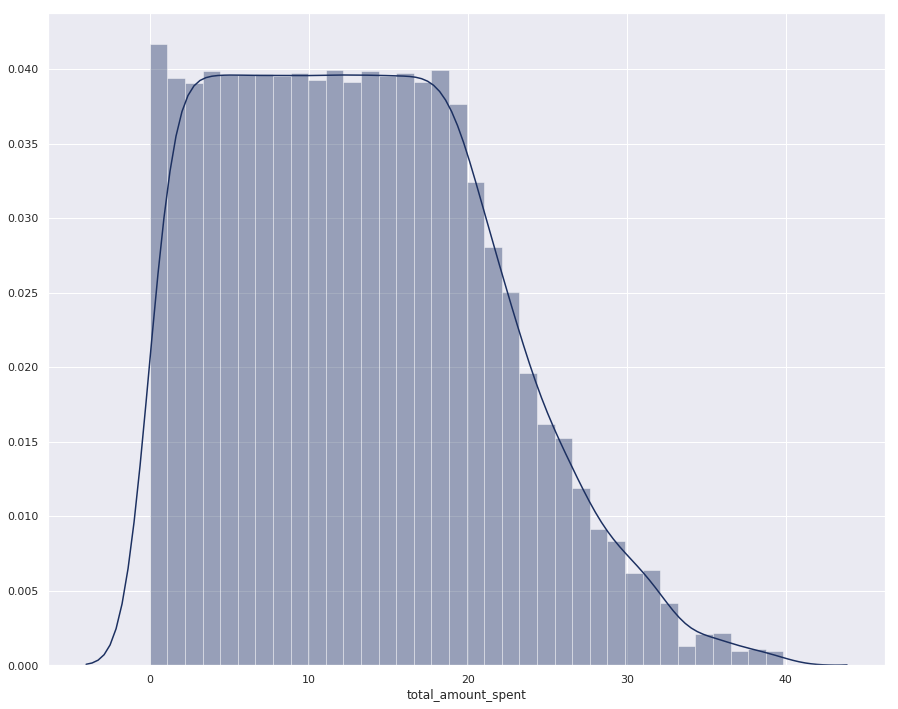

In [100]:
sns.distplot(TAS['total_amount_spent'],color='#1C3061')

In [102]:
TYPE='activity'
FOLDS=5
SEED=42
select_model='lgb'

documents = [TaggedDocument(str(idx), doc) for idx, doc in zip(simil_test_test.index, np.round(simil_test_test, 1).values.tolist())]
dov2vec = Doc2Vec(documents, vector_size=1, window=3, min_count=10, workers=-1)
user2vec = np.concatenate([dov2vec.infer_vector(str(acc_id)) for acc_id in simil_test_test.index])
simil_test_test['similarity'] = user2vec
simil_test = pd.merge(simil_test, pd.concat([simil_test_test.reset_index()['acc_id'], pd.DataFrame(pca_component, columns=['pca']), pd.DataFrame(svd_component, columns=['svd'])], 1), 
                      how='left', on='acc_id')
simil_test = pd.merge(simil_test, pd.DataFrame(simil_test_test.reset_index()[['acc_id', 'similarity']].values, columns=['acc_id', 'similarity']), how='left', on='acc_id')
dummy_df = pd.get_dummies(simil_test.groupby('acc_id')['week'].first()).reset_index()
dummy_df.columns = ['acc_id', 'enter_week1', 'enter_week2', 'enter_week3', 'enter_week4']
simil_test = pd.merge(simil_test, dummy_df, how='left', on='acc_id')

print('similarity start')
train = simil_test.iloc[:train.shape[0], :]
test1 = simil_test.iloc[train.shape[0]:train.shape[0]+test1.shape[0], :].reset_index(drop=True)
test2 = simil_test.iloc[-test2.shape[0]:, :].reset_index(drop=True)

print(train.shape, test1.shape, test2.shape)

train = feature_selection(train, fis)
test1 = feature_selection(test1, fis)
test2 = feature_selection(test2, fis)


main_model = model(train, train_label, test1, test2, TYPE, FOLDS, SEED)
print('start main_model')
main_model.labeling()
st = main_model.train_st(PARAMS_ST, 5000, select_model)
# oof_st = main_model.infer_oof(select_model)

main_model.labeling_tas(train_payment)
tas = main_model.train_tas(PARAMS_TAS, 50000, select_model)
# oof_tas = main_model.infer_tas_oof(select_model)

NameError: ignored

In [0]:
score_function(oof_transform(oof_st, oof_tas), true_train_label)

34554.54792916119


34554.54792916119

In [110]:
train_activity.columns

Index(['day', 'acc_id', 'char_id', 'server', 'playtime', 'npc_kill',
       'solo_exp', 'party_exp', 'quest_exp', 'rich_monster', 'death', 'revive',
       'exp_recovery', 'private_shop', 'game_money_change', 'enchant_count',
       'game_money_change_abs', 'week'],
      dtype='object')

In [0]:
feature_imp = pd.DataFrame(sorted(zip(main_model.load('model_tas')['model0'].feature_importance(), main_model.load('feature'))), columns=['Value','Feature'])
joblib.dump(feature_imp, "/content/drive/My Drive/bigcontest2019/scripts/hh's work/feature_importance/feature_importance2.ckpt")

["/content/drive/My Drive/bigcontest2019/scripts/hh's work/feature_importance/feature_importance2.ckpt"]

In [0]:
fis = joblib.load("/content/drive/My Drive/bigcontest2019/scripts/hh's work/feature_importance/feature_importance.ckpt")
fis = fis.loc[fis['Value']>25, 'Feature'].tolist()
fis.extend(['acc_id', 'week'])

def feature_selection(data, fis):
    df = data.copy()
    
    sum_columns = df.columns[[column[-3:]=='sum' for column in df.columns]]
    df = df[df.columns[(pd.Series(df.columns).isin(fis)) | (pd.Series(df.columns).isin(sum_columns))]]
    
    playtimesum = df['playtimesum']
    for column in sum_columns[1:]:
        df['derive' + str(column)] = df[column]/playtimesum
    else:
        df = df[fis]
        return df

TYPE='activity'
FOLDS=5
SEED=42
select_model='rf'

main_model = model(feature_selection(train, fis), train_label, feature_selection(test1, fis), feature_selection(test2, fis), TYPE, FOLDS, SEED)
print('start main_model')
main_model.labeling()
oof_st_rf = main_model.joblib_load_oof(select_model)

main_model.labeling_tas(train_payment)
oof_tas_rf = main_model.joblib_load_tas_oof(select_model)

start main_model


In [0]:
# feature_imp = pd.DataFrame(sorted(zip(main_model.load('model_tas')['model0'].feature_importance(), main_model.load('feature'))), columns=['Value','Feature'])
# joblib.dump(feature_imp, "/content/drive/My Drive/bigcontest2019/scripts/hh's work/feature_importance/feature_importance.ckpt")

In [0]:
oof_tas_ensembles = oof_tas_rf.copy()
oof_tas_ensembles['infer_total_amount_spent'] = oof_tas_rf['infer_total_amount_spent']*0.05 + oof_tas_lgb['infer_total_amount_spent']*0.95

# 예측, 실제
score_function(oof_transform(oof_st_lgb, oof_tas_ensembles), true_train_label)

35190.25717482952


35190.25717482952

In [0]:
main_pred_st1, main_pred_st2 = main_model.infer_pred()
main_pred_tas1, main_pred_tas2 = main_model.infer_tas_pred()

In [0]:
pred_transform(main_pred_st1, main_pred_tas1, test1_activity['acc_id'].unique()).to_csv('/content/test1_predict.csv', index=False)
pred_transform(main_pred_st2, main_pred_tas2, test2_activity['acc_id'].unique()).to_csv('/content/test2_predict.csv', index=False)

In [0]:
# act_pred_st1, act_pred_st2 = activity_model.infer_pred()
# act_pred_tas1, act_pred_tas2 = activity_model.infer_tas_pred()

# pay_pred_st1, pay_pred_st2 = payment_model.infer_pred()
# pay_pred_tas1, pay_pred_tas2 = payment_model.infer_tas_pred()

# tra_pred_st1, tra_pred_st2 = trade_model.infer_pred()
# tra_pred_tas1, tra_pred_tas2 = trade_model.infer_tas_pred()

# com_pred_st1, com_pred_st2 = combat_model.infer_pred()
# com_pred_tas1, com_pred_tas2 = combat_model.infer_tas_pred()

# ple_pred_st1, ple_pred_st2 = pledge_model.infer_pred()
# ple_pred_tas1, ple_pred_tas2 = pledge_model.infer_tas_pred()

In [0]:
oop_st = pd.concat([act_oof_st, pay_oof_st, tra_oof_st, com_oof_st, ple_oof_st]).groupby('acc_id').median().reset_index()
# oop_st = pd.concat([act_oof_st, pay_oof_st, tra_oof_st, com_oof_st, ple_oof_st]).groupby('acc_id').agg(lambda x: x.value_counts().index[0]).reset_index()
oop_tas = pd.concat([act_oof_tas, pay_oof_tas, tra_oof_tas, com_oof_tas, ple_oof_tas]).groupby('acc_id').median().reset_index()

In [0]:
# metrics
from scripts.metrics.score_function import score_function

def oof_transform(st, tas):
    st_t = st.copy()
    tas_t = tas.copy()

    tas_t.loc[tas['infer_total_amount_spent']<0, 'infer_total_amount_spent'] = 0
    
    oof_df = pd.merge(st_t, tas_t, how='left', on='acc_id')[['acc_id', 'infer_survival_time', 'infer_total_amount_spent']]
    oof_df.columns = ['acc_id', 'survival_time', 'amount_spent']
    oof_df['amount_spent'] = oof_df['amount_spent']/oof_df['survival_time']
    return oof_df

def pred_transform(st, tas, acc_id):
    st_t = st.copy()
    tas_t = tas.copy()
    
    st_t['survival_time'] = st_t.drop(columns='acc_id').median(1)
    tas_t['amount_spent'] = tas_t.drop(columns='acc_id').median(1)
    
    pred_df = pd.merge(st_t, tas_t, how='left', on='acc_id')[['acc_id', 'survival_time', 'amount_spent']]
    pred_df['amount_spent'] = pred_df['amount_spent']/pred_df['survival_time']
    
    pred_df = pred_df[pred_df['acc_id'].isin(acc_id)]
    return pred_df

# 예측, 실제
score_function(oof_transform(act_oof_st, act_oof_tas),
               true_train_label)

NameError: ignored

# submission

In [0]:
pred1_st = pd.concat([act_pred_st1, pay_pred_st1, tra_pred_st1, com_pred_st1, ple_pred_st1]).groupby('acc_id').median().reset_index()
pred1_tas = pd.concat([act_pred_tas1, pay_pred_tas1, tra_pred_tas1, com_pred_tas1, ple_pred_tas1]).groupby('acc_id').median().reset_index()

pred2_st = pd.concat([act_pred_st2, pay_pred_st2, tra_pred_st2, com_pred_st2, ple_pred_st2]).groupby('acc_id').median().reset_index()
pred2_tas = pd.concat([act_pred_tas2, pay_pred_tas2, tra_pred_tas2, com_pred_tas2, ple_pred_tas2]).groupby('acc_id').median().reset_index()

In [0]:
pred_transform(pred1_st, pred1_tas, test1_activity['acc_id'].unique()).to_csv('/content/test1_predict.csv', index=False)
pred_transform(pred2_st, pred2_tas, test2_activity['acc_id'].unique()).to_csv('/content/test2_predict.csv', index=False)

In [0]:
pred_transform(act_pred_st1, act_pred_tas1, test1_activity['acc_id'].unique()).to_csv('/content/test1_predict.csv', index=False)
pred_transform(act_pred_st2, act_pred_tas2, test2_activity['acc_id'].unique()).to_csv('/content/test2_predict.csv', index=False)

In [84]:
train_s = pd.read_csv('/content/train.csv')

ParserError: ignored